# RNN

In [1]:
import torch
import math
import torch.nn as nn

## myRNNのスクラッチ
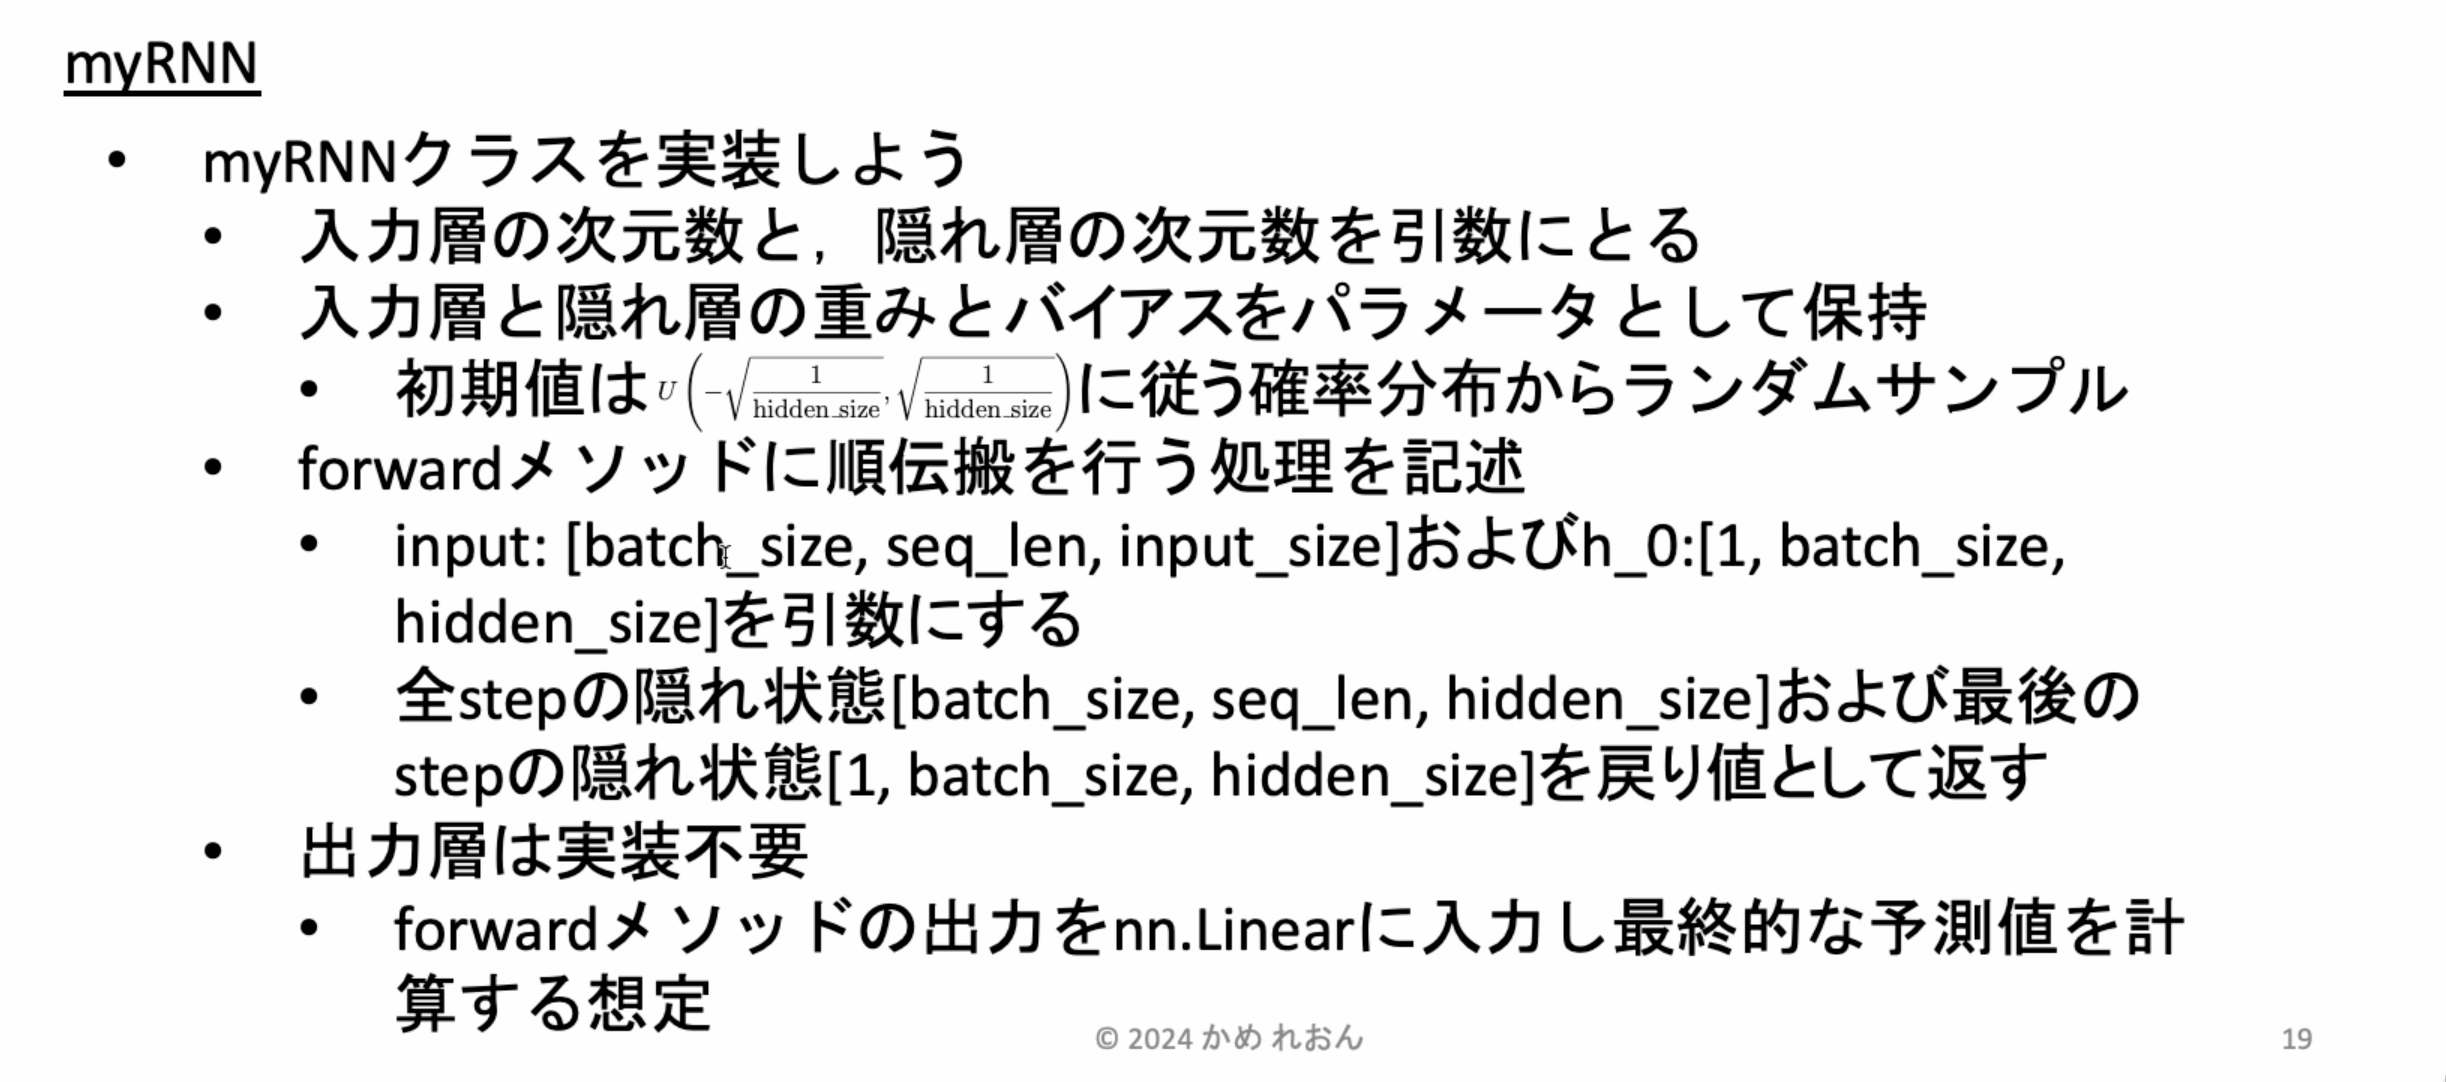

In [2]:
class myRNN:
    def __init__(self, input_size, hidden_size):
        # 重み(W_in, W_h), バイアス(b_in, b_h)の初期化
        self.hidden_size = hidden_size

        # pytorchのnn.RNNの重みとバイアスの初期値に合わせる ~U(-1/√hidden_size, 1/√hidden_size)
        init_range = 1.0/math.sqrt(hidden_size)
        self.W_in = torch.empty(hidden_size, input_size).uniform_(-init_range, init_range)
        self.W_h = torch.empty(hidden_size, hidden_size).uniform_(-init_range, init_range)

        self.b_in = torch.empty(hidden_size).uniform_(-init_range, init_range)
        self.b_h = torch.empty(hidden_size).uniform_(-init_range, init_range)
        
    def forward(self, input, h_0=None):
        # input（batch firstを想定）: [batch_size, seq_len, input_size]
        batch_size, seq_len, _ = input.size()

        if h_0 is None:
            h_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)

        h = h_0 # [1, batch_size, hidden_size]
        outputs = []

        # 文章の単語数でfor文を繰り返す
        for i in range(seq_len):
            # [batch_size, hidden_size]
            h = torch.tanh(input[:, i]@self.W_in.T + self.b_in + h.squeeze(0)@self.W_h.T + self.b_h)
            outputs.append(h.unsqueeze(1))# [batch_size, hidden_size] -> # [batch_size, 1, hidden_size]
        output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return output_seq, h_n

In [3]:
input_size = 10
hidden_size = 3
batch_size = 8
seq_len = 5

# サンプルのTensor
input_tensor = torch.randn(batch_size, seq_len, input_size)  # これがいくつかの文章のミニバッチになる
rnn = myRNN(input_size, hidden_size)
print(input_tensor.shape)

torch.Size([8, 5, 10])


In [4]:
output_seq, h_n = rnn.forward(input_tensor)
print(output_seq.shape)
print(h_n.shape)

torch.Size([8, 5, 3])
torch.Size([1, 8, 3])


In [5]:
# 以下コードメモ

In [6]:
# .uniform()は正規分布化する関数
init_range = 1.0/math.sqrt(hidden_size)
W_in = torch.empty(hidden_size, input_size).uniform_(-init_range, init_range)
W_in.uniform_(-init_range, init_range)

NameError: name 'W_in' is not defined

In [7]:
hidden_size = 3
input_size = 5
batch_size = 9
h_0 = torch.zeros(1, batch_size, hidden_size)
h_0

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

## RNNモデルの実装

myRNNModel
- myRNNModelクラスを実装する
    - 前回作成したmyRNNクラスと出力層(nn.Linear)を組み合わせる
    - 新たに出力層の次元数(output_size)を引数として渡す
    - forwardメソッドでは、最後の隠れ状態を出力層に入力し、最終的な結果を返す
    - (NERのようなケースでは、すべての隠れ状態を出力層に入力する)
    - 最後の活性化関数は不要(通常Pytorchの実装では損失関数に委ねる)

In [8]:
class myRNNModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.rnn = myRNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, h_n = self.rnn.forward(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        out = self.fc(h_n.squeeze(0))
        return out

In [9]:
output_size = 2 # ２クラス問題
model = myRNNModel(input_size, hidden_size, output_size)
out = model.forward(input_tensor)
# ミニバッチ8の2クラス問題
out.size()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x10 and 5x3)

## PytorchのRNNを使う

nn.RNN

- torch.nn.RNNにRNNユニットが既に実装されている
- 基本的な使い方は前回までのレクチャーで実装したmyRNNと同様
- myRNNModelクラスで主に以下の部分を変更
    - nn.Moduleを継承
    - myRNNの代わりにnn.RNNを使用する
        - batch_firstにTrueを指定することで、入力を[batch_size, seq_len, input_size]とできる
    - .forwardを明示的にcallする必要はない

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, h_n = self.rnn(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        # out = self.fc(h_n.squeeze(0))
        out = self.fc(output_seq[:, -1, :]) #[batch_size, 1, hidden_size]
        # NER: (many to many)
        # out = self.fc(output_seq)
        return out

In [11]:
input_size = 10
hidden_size = 3
batch_size = 8
seq_len = 5
model = RNNModel(input_size, hidden_size, output_size)
out = model(input_tensor)
out.size()

torch.Size([8, 2])

In [12]:
# モデルのパラメータ
# rnn(W,bのinput,hidden)とfc(全結合層)がある
# W_in: 隠れ層x入力層
# W_h: 隠れ層x隠れ層
# b_in: 隠れ層
# b_h: 隠れ層
# fc.W: 出力x隠れ層
# fc.b: 出力
for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")

rnn.weight_ih_l0: torch.Size([3, 10])
rnn.weight_hh_l0: torch.Size([3, 3])
rnn.bias_ih_l0: torch.Size([3])
rnn.bias_hh_l0: torch.Size([3])
fc.weight: torch.Size([2, 3])
fc.bias: torch.Size([2])


## RNN Backpropagation

- 作成したmyRNNクラスに誤差逆伝播の処理を追加する
    - backwardメソッドを実装する
    - 出力層の勾配dL/dhを引数にする

In [13]:
class myRNN:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        init_range = 1.0/math.sqrt(hidden_size)
        self.W_in = torch.empty(hidden_size, input_size).uniform_(-init_range, init_range).requires_grad_(True)
        self.W_h = torch.empty(hidden_size, hidden_size).uniform_(-init_range, init_range).requires_grad_(True)

        self.b_in = torch.empty(hidden_size).uniform_(-init_range, init_range).requires_grad_(True)
        self.b_h = torch.empty(hidden_size).uniform_(-init_range, init_range).requires_grad_(True)
        
    def forward(self, input, h_0=None):
        # input: [batch_size, seq_len, input_size]
        self.input = input
        self.h_0 = h_0
        batch_size, self.seq_len, _ = input.size()

        if h_0 is None:
            self.h_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)

        h = self.h_0 # [1, batch_size, hidden_size]
        outputs = []
        for i in range(self.seq_len):
            # [batch_size, hidden_size]
            h = torch.tanh(input[:, i]@self.W_in.T + self.b_in + h.squeeze(0)@self.W_h.T + self.b_h)
            outputs.append(h.unsqueeze(1))# [batch_size, hidden_size] -> # [batch_size, 1, hidden_size]
        self.output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return self.output_seq, h_n

    def backward(self, out_grad):
        
        # 重みとバイアスの勾配
        self.grad_W_in_list = []
        self.grad_W_h_list = []
        self.grad_b_in_list = []
        self.grad_b_h_list = []
        
        # 隠れ層hの勾配
        self.grad_h_list = []
        self.grad_h_tanh_list = []

        # 勾配の初期化
        grad_W_in = torch.zeros_like(self.W_in)
        grad_W_h = torch.zeros_like(self.W_h)
        grad_b_in = torch.zeros_like(self.b_in)
        grad_b_h = torch.zeros_like(self.b_h)
        grad_h = torch.zeros_like(self.h_0)

        # 各ステップの隠れ状態の勾配を初期化
        grad_output_seq = torch.zeros_like(self.output_seq) # [batch_size, seq_len, hidden_size] 
        grad_output_seq[:, -1, :] = out_grad

        # 各ステップにおける勾配を計算
        for i in reversed(range(self.seq_len)):

            # tanhの微分 (dh*(1-dh^2))
            grad_h_tanh = grad_output_seq[:, i] * (1 - self.output_seq[:, i].pow(2))
            grad_W_in += torch.sum(grad_h_tanh.unsqueeze(2)*self.input[:, i].unsqueeze(1), dim=0)
            grad_b_in += torch.sum(grad_h_tanh, dim=0)
            grad_b_h += torch.sum(grad_h_tanh, dim=0)
            grad_h = grad_h_tanh @ self.W_h
            

            if i != 0:
                grad_output_seq[:, i-1] = grad_h
                # self.output_seqを使って計算
                grad_W_h += torch.sum(grad_h_tanh.unsqueeze(2)*self.output_seq[:, i-1].unsqueeze(1), dim=0)
            else:
                # h_0を使って計算
                grad_W_h += torch.sum(grad_h_tanh.unsqueeze(2)*self.h_0.squeeze(0).unsqueeze(1), dim=0)           
            # 勾配を保持
            self.grad_W_in_list.append(grad_W_in.clone())
            self.grad_W_h_list.append(grad_W_h.clone())
            self.grad_b_in_list.append(grad_b_in.clone())
            self.grad_b_h_list.append(grad_b_h.clone())
            self.grad_h_list.append(grad_h.clone())
            self.grad_h_tanh_list.append(grad_h_tanh.clone())

        # self.W_in -= grad_W_in

class myRNNModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.rnn = myRNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, self.h_n = self.rnn.forward(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        out = self.fc(self.h_n.squeeze(0))
        return out

In [14]:
class myRNN:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        init_range = 1.0/math.sqrt(hidden_size)
        self.W_in = torch.empty(hidden_size, input_size).uniform_(-init_range, init_range).requires_grad_(True)
        self.W_h = torch.empty(hidden_size, hidden_size).uniform_(-init_range, init_range).requires_grad_(True)

        self.b_in = torch.empty(hidden_size).uniform_(-init_range, init_range).requires_grad_(True)
        self.b_h = torch.empty(hidden_size).uniform_(-init_range, init_range).requires_grad_(True)
        
    def forward(self, input, h_0=None):
        # input: [batch_size, seq_len, input_size]
        self.input = input
        self.h_0 = h_0
        batch_size, self.seq_len, _ = input.size()

        if h_0 is None:
            self.h_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)

        h = self.h_0 # [1, batch_size, hidden_size]
        outputs = []
        for i in range(self.seq_len):
            # [batch_size, hidden_size]
            h = torch.tanh(input[:, i]@self.W_in.T + self.b_in + h.squeeze(0)@self.W_h.T + self.b_h)
            outputs.append(h.unsqueeze(1))# [batch_size, hidden_size] -> # [batch_size, 1, hidden_size]
        self.output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return self.output_seq, h_n

    def backward(self, out_grad):

        self.grad_W_in_list = []
        self.grad_W_h_list = []
        self.grad_b_in_list = []
        self.grad_b_h_list = []

        self.grad_h_list = []
        self.grad_h_tanh_list = []

        # 勾配の初期化
        grad_W_in = torch.zeros_like(self.W_in)
        grad_W_h = torch.zeros_like(self.W_h)
        grad_b_in = torch.zeros_like(self.b_in)
        grad_b_h = torch.zeros_like(self.b_h)
        grad_h = torch.zeros_like(self.h_0)

        # 各ステップの隠れ状態の勾配を初期化
        grad_output_seq = torch.zeros_like(self.output_seq) # [batch_size, seq_len, hidden_size] 
        grad_output_seq[:, -1, :] = out_grad

        # 各ステップにおける勾配を計算
        for i in reversed(range(self.seq_len)):

            # tanhの微分 (dh*(1-dh^2))
            grad_h_tanh = grad_output_seq[:, i] * (1 - self.output_seq[:, i].pow(2))
            grad_W_in += torch.sum(grad_h_tanh.unsqueeze(2)*self.input[:, i].unsqueeze(1), dim=0)
            grad_b_in += torch.sum(grad_h_tanh, dim=0)
            grad_b_h += torch.sum(grad_h_tanh, dim=0)
            grad_h = grad_h_tanh @ self.W_h
            

            if i != 0:
                grad_output_seq[:, i-1] = grad_h
                # self.output_seqを使って計算
                grad_W_h += torch.sum(grad_h_tanh.unsqueeze(2)*self.output_seq[:, i-1].unsqueeze(1), dim=0)
            else:
                # h_0を使って計算
                grad_W_h += torch.sum(grad_h_tanh.unsqueeze(2)*self.h_0.squeeze(0).unsqueeze(1), dim=0)           
            # 勾配を保持
            self.grad_W_in_list.append(grad_W_in.clone())
            self.grad_W_h_list.append(grad_W_h.clone())
            self.grad_b_in_list.append(grad_b_in.clone())
            self.grad_b_h_list.append(grad_b_h.clone())
            self.grad_h_list.append(grad_h.clone())
            self.grad_h_tanh_list.append(grad_h_tanh.clone())

        # self.W_in -= grad_W_in

class myRNNModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.rnn = myRNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, self.h_n = self.rnn.forward(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        out = self.fc(self.h_n.squeeze(0))
        return out

## 実装したRNNのテスト

- 作成したRNNクラスのbackwardを、pytorchのautograと比較して結果が等しくなることを確認する
- 出力層の勾配はtorch.autograd.grad関数を使用して求める

In [16]:
# backwardのテスト
input_size = 3
hidden_size = 2
batch_size = 3
seq_len = 5

# 入力データと正解ラベルの定義
input_tensor = torch.randn(batch_size, seq_len, input_size)
target = torch.tensor([0]*batch_size)

# モデルのインスタンス作成
model = myRNNModel(input_size, hidden_size, output_size)
# forward
output = model.forward(input_tensor)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()
# 損失計算
loss = criterion(output, target)
# 出力層の勾配計算
out_grad = torch.autograd.grad(loss, model.h_n, retain_graph=True)[0]
# スクラッチのbackward
model.rnn.backward(out_grad)
# autograd
loss.backward()

print("Autograd Gradient - W_in:", model.rnn.W_in.grad)
print("Manual Gradient - W_in:", model.rnn.grad_W_in_list[-1])
print("======================")
print("Autograd Gradient - W_h:", model.rnn.W_h.grad)
print("Manual Gradient - W_h:", model.rnn.grad_W_h_list[-1])
print("======================")
print("Autograd Gradient - b_in:", model.rnn.b_in.grad)
print("Manual Gradient - b_in:", model.rnn.grad_b_in_list[-1])
print("======================")
print("Autograd Gradient - b_h:", model.rnn.b_h.grad)
print("Manual Gradient - b_h:", model.rnn.grad_b_h_list[-1])

Autograd Gradient - W_in: tensor([[-0.0053,  0.0085, -0.0093],
        [-0.1857, -0.0109, -0.0153]])
Manual Gradient - W_in: tensor([[-0.0053,  0.0085, -0.0093],
        [-0.1857, -0.0109, -0.0153]], grad_fn=<CloneBackward0>)
Autograd Gradient - W_h: tensor([[0.0044, 0.0140],
        [0.0664, 0.1277]])
Manual Gradient - W_h: tensor([[0.0044, 0.0140],
        [0.0664, 0.1277]], grad_fn=<CloneBackward0>)
Autograd Gradient - b_in: tensor([-0.0432, -0.1951])
Manual Gradient - b_in: tensor([-0.0432, -0.1951], grad_fn=<CloneBackward0>)
Autograd Gradient - b_h: tensor([-0.0432, -0.1951])
Manual Gradient - b_h: tensor([-0.0432, -0.1951], grad_fn=<CloneBackward0>)
